Load necessary modules listed in ``requirements.txt``

In [3]:
import cv2
import librosa
import librosa.display
import numpy as np
import pydub
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import cv2
import warnings
warnings.filterwarnings("ignore")

Load audio files from dataset

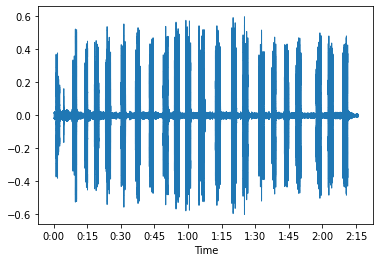

In [14]:
y, sr = librosa.load('build/audio/mp3/Parus-major-168221.mp3')
audio = librosa.display.waveshow(y=y, sr=sr)

Trim down audio length and render to mel spectrogram

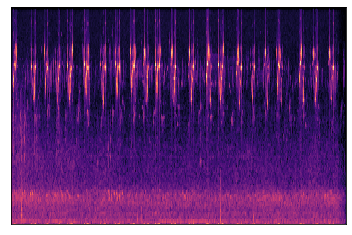

In [13]:
mel_s = librosa.feature.melspectrogram(y=y, sr=sr)
mel_s = librosa.power_to_db(mel_s, ref=np.max)
image = librosa.display.specshow(mel_s)

Load dataset CSV file and create numpy array for file names and labels

In [65]:
df = pd.read_csv('build/audio/metadata.csv', usecols=[0, 3])

X = df['Recording_ID'].values

labels = df['English_name'].values
Y = []
for category in labels:
    class_num = labels.tolist().index(category)
    Y.append(class_num)
Y = np.array(Y)

print(df.head())

   Recording_ID      English_name
0        234032  Common Chaffinch
1        168175  Common Chaffinch
2        213928  Common Chaffinch
3        512407  Common Chaffinch
4        177404  Common Chaffinch


Load image

In [68]:
ds_train = tf.data.Dataset.from_tensor_slices((X, Y))
directory = 'path to image folder'

def read_image(image_file, label):
    image = tf.io.read_file(directory + image_file)
    image = tf.image.decode_image(image, channels=1, dtype=tf.float32)
    return image, label

ds_train = ds_train.map(read_image).batch(2)

Build model similar to Model-2 used in: https://www.researchgate.net/publication/341172446_Environmental_sound_classification_using_a_regularized_deep_convolutional_neural_network_with_data_augmentation

In [ ]:
model = keras.Sequential(
    [
        # Input (image width, image height, channels)
        layers.Input(160, 120, 1),

        # Layer 1 
        # Two dimensional convolutional layer with 24 filters, 5*5 receptive field
        # 3*3 strided max pooling function
        layers.Conv2D(24, (5,5), activation='relu'),
        layers.MaxPooling2D(strides=(3,3), pool_size=(2,2)),

        # Layer 2 
        # Two dimensional convolutional layer with 36 filters, 4*4 receptive field
        # 2*2 strided max pooling function
        layers.Conv2D(36, (4,4), activation='relu', padding='valid'),
        layers.MaxPooling2D(strides=(2,2), pool_size=(2,2)),

        # Layer 3 
        # Two dimensional convolutional layer with 48 filters, 3*3 receptive field
        # No max pooling function
        layers.Conv2D(48, (3,3), activation='relu', padding='valid'),

        # Flatten convolutional layers output to one dimension for dense layers to use
        layers.Flatten(),

        # Layer 4 
        # Dense layer with 60 hidden units and dropout rate of 0.5
        layers.Dense(60, activation='relu'),
        layers.Dropout(.5),

        # Layer 5 
        # Dense layer with the same amount of hidden units as categories
        # Softmax activation function is used
        layers.Dense(len(np.unique(labels)), activation='softmax')
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True),],
    metrics=["accuracy"],
)

Begin training the model

In [ ]:
model.fit(ds_train, epochs=100, batch_size=32)